# Author: Alireza Mohseni(810199259) - Reza Dehghani(810199159)
Spring 1400

# 1) Variational Autoecoders

## 1-1) Import Libaries

<h3 align="right" dir="rtl" >
برای شروع ابتدا کتابخانه های مورد نیاز را import میکنیم
</h3>

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.losses import binary_crossentropy
from keras.layers.merge import concatenate
from keras import backend as K
from IPython.display import SVG
from scipy.stats import norm

## 1-2) Download Dataset

<h3 align="right" dir="rtl" >
در مرحله بعد مجموعه داده مورد نیاز را دانلود کرده ، به shape دلخواه تبدیل میکنیم و سپس آنرا با تقسیم بر 255 نرمال میکنیم.
همچنین برای درک شهود بهتر نسبت به داده ها تعدادی از آنها رسم شده اند
</h3>

11501568/11490434 [==============================] - 0s 0us/step
X_train:  (60000, 28, 28, 1)
Y_train:  (60000,)
X_test:   (10000, 28, 28, 1)
Y_test:   (10000,)


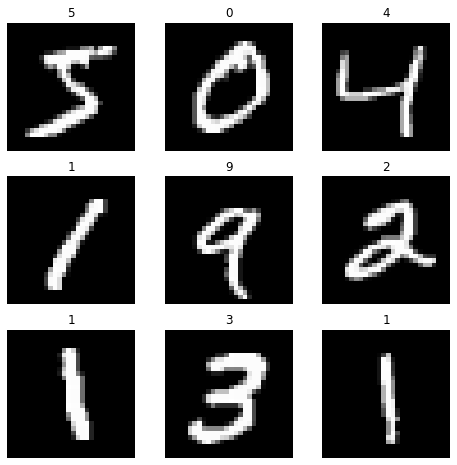

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.expand_dims(X_train, -1).astype("float32") / 255
X_test = np.expand_dims(X_test, -1).astype("float32") / 255

print('X_train: ' ,X_train.shape)
print('Y_train: ' ,y_train.shape)
print('X_test:  ' ,X_test.shape)
print('Y_test:  ' ,y_test.shape)

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i,:,:,0], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

## 1-3) Define Ploting Functions

<h3 align="right" dir="rtl" >
در این مرحله توابعی را برای رسم نمودار های مورد نیاز تعریف میکنیم که پس از آموزش مدل ، خروجی آن به شکلی مناسب نمایش داده شود.
</h3>

<h3 align="right" dir="rtl" >
تابع plot_history برای رسم مقادیر loss در حین آموزش شبکه میباشد
</h3>

In [3]:
def plot_history(epochs,history):
    plt.figure(figsize=(8,5))
    plt.plot(range(epochs), history.history['loss'], label='Total loss')
    plt.plot(range(epochs), history.history['kl_loss'], label='KL loss')
    plt.plot(range(epochs),history.history["reconstruction_loss"], label='Reconstruction loss')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

<h3 align="right" dir="rtl" >
تابع plot_latent_space_cluster فضای ثانویه و خروجی شبکه را رسم میکند.
</h3>
<h3 align="right" dir="rtl" >
در نمودار اول عکس های تولید شده توسط شبکه در حالت grid نمایش داده میشوند.
</h3>
<h3 align="right" dir="rtl" >
در نمودار دوم مقدار بدست آمده برای هر ورودی در فضای ثانویه را بوسیله scatter plot رسم میکنیم که بتوانیم به شکل شهودی توزیع آنهارا ببینیم.
</h3>

In [4]:
def plot_latent_space_cluster(x_pred_grid,latent_space,y_true,n=10, figsize=20):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(figsize, figsize/2))
    ax1.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
    ax1.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)
    cbar = ax2.scatter(latent_space[:, 0], latent_space[:, 1], c=y_true, cmap=plt.cm.jet)
    fig.colorbar(cbar, ax=ax2)
    ax2.set_xlabel('z_1')
    ax2.set_ylabel('z_2')
    plt.show()

<h3 align="right" dir="rtl" >
با استفاده از تابع plot_after_before خروجی نهایی شبکه را در کنار ورودی های متناظر رسم میکنیم که بتوانیم با یکدیگیر مقایسه کنیم.
</h3>

In [5]:
def plot_after_before(X,x_pred_grid,n=10,figsize=20):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(figsize, figsize/2))
    ax1.imshow(np.block(list(map(list, X[:n*n].reshape(n,n,28,28)))), cmap='gray')
    ax1.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)
    ax1.set_title("Before")
    ax2.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
    ax2.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)
    ax2.set_title("After")
    plt.show()

## 1-4) Define Sampling Function

<h3 align="right" dir="rtl" >
تابع Sampling از فضای ثانویه بدست آمده نمونه برداری میکند و همچنین عمل reparametrization را صورت میدهد
</h3>

In [6]:
def sampling(args):
    z_mu, z_log_sigma,latent_dim = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

## 1-5) Encoder Model

<h3 align="right" dir="rtl" >
در این قسمت مدل انکودر خودرا تعریف میکنیم که وظیفه آن این است ورودی شبکه را به فضای ثانویه ببرد و میانگین و واریانس توزیع آنهارا در آن فضا بدست آورد. مدل استفاده شده ابتدا دولایه کانولوشنی به ترتیب با 32 و 64 فیلتر با کرنل سایز 3 دارد و در ادامه خروجی flat شده و به لایه dense با 16 نورون متصل میشود. در مرحله بعد خروجی این لایه به دولایه مجزا داده میشود. لایه اول Z_mean با دو نورون است که ماینگین فضای ثانویه را به صورت دوبعدی بدست میآورد و لایه دیگر نیز Z_log_var مباشد که بازهم دو نورون دارد و لگاریتم واریانس فضای ثانویه را به صورت دوبعدی بدست می آورد.در تمامی لایه ها از تابع فعالساز Relu استفاده شده است.
</h3>

In [7]:
def make_VAEencoder(latent_dim):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2,padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu",strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = layers.Lambda(sampling)([z_mean, z_log_var,latent_dim])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

## 1-6) Decoder Model

<h3 align="right" dir="rtl" >
در این قسمت مدل دیکودر را تعریف میکنیم که وظیفه آن برگرداندن داده ها از فضای ثانویه به فضای اولیه میباشد. معماری این مدل عکس انکودر میباشد و ابتدا داده ها را ها را از فضای latent با دو بعد دریافت میکند و سپس آنهارا بوسیله لایه های dense و Convolution Transpose به فضای 28*28 اولیه میبرد.
یک تفاوت دیگر آن با انکودر نیز این است که در لایه آخر از تابع فعالساز sigmoid استفاده شده است.
</h3>

In [8]:
def make_VAEdecoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

## 1-7) VAE Model

<h3 align="right" dir="rtl" >
پس از تعریف مدل های انکودر و دیکودر ، در این قسمت آنهارا ترکیب میکنیم و مدل VAE را تعریف میکنیم.
برای اینکار یک کلاس جدید به نام VAE تعریف میکنیم که از کلاس مدل کتابخانه keras ارث برده است. سپس متد train_step آنرا دوباره تعریف میکنم.
در این متد داده های ورودی را ابتدا به مدل encoder میدهیم که 3 خروجی z_mean ، z_log_var و z که sample شده دو پارامتر قبل است ، برگردانده میشوند. در مرحله بعد خروجی z را به مدل decoder میدهیم که آنرا به فضای اولیه برگرداند. پس از بدست آمدن خروجی شبکه در فضای اولیه خطای آنرا نسبت به ورودی اولیه شبکه , KL Divergence آنرا بدست میآوریم و مقدار loss نهایی و metric های تعریف شده برای یادگیری شبکه را آپدیت میکنیم.
</h3>

In [9]:
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = 2
        self.encoder = make_VAEencoder(self.latent_dim)
        self.decoder = make_VAEdecoder(self.latent_dim)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## 1-8) Define Display Callback

<h3 align="right" dir="rtl" >
در این قسمت یک callback تعریف میکنیم که نسبت به ورودی که میگیرد ، هر چند ایپاک یکبار خروجی شبکه را رسم میکند. برای اینکار پس از اتمام هر ایپاک ، شمارنده ایپاک بررسی میشود که به interval در نظر گرفته شده رسیده است یا خبر و اگر رسیده بود با مدل آموزش دیده در آن لحظه فضای ثانویه و خروجی شبکه را بدست آورده و با استفاده از تابع plot_latent_space_cluster نمودارهایشان را رسم میکنیم.
</h3>


In [10]:
class DisplayCallbackVAE(keras.callbacks.Callback):
    def __init__(self,data,n,i,patience=0):
        super(DisplayCallbackVAE, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.interval=i
        self.data = data
        self.n = n

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0 or epoch+1 == self.params.get('epochs', -1):
            img_rows, img_cols, img_chns = self.data[0].shape[1:]
            latent_dim = 2
            latent_space = np.array(vae.encoder.predict(self.data[0]))
            quantile_min = 0.01
            quantile_max = 0.99
            z1 = norm.ppf(np.linspace(quantile_min, quantile_max, self.n))
            z2 = norm.ppf(np.linspace(quantile_max, quantile_min, self.n))
            z_grid = np.dstack(np.meshgrid(z1, z2))
            x_pred_grid = vae.decoder.predict(z_grid.reshape(self.n*self.n, latent_dim)).reshape(self.n, self.n, img_rows, img_cols)
            plot_latent_space_cluster(x_pred_grid,latent_space[0],self.data[1],n=self.n, figsize=20)

## 1-9) Train VAE Model

<h3 align="right" dir="rtl" >
در این مرحله همه مدل ها تعریف شده و آماده اند و میتوانیم آنرا با استفاده از مجموعه داده آموزش دهیم. برای اینکار از بهینه ساز Adam استفاده میکنیم و شبکه را 30 ایپاک آموزش میدهیم و هر 10 ایپاک یکبار نیز خروجی شبکه رسم خواهد شد.
</h3>


Epoch 1/30
469/469 [==============================] - 36s 10ms/step - loss: 273.0284 - reconstruction_loss: 219.5423 - kl_loss: 1.1768


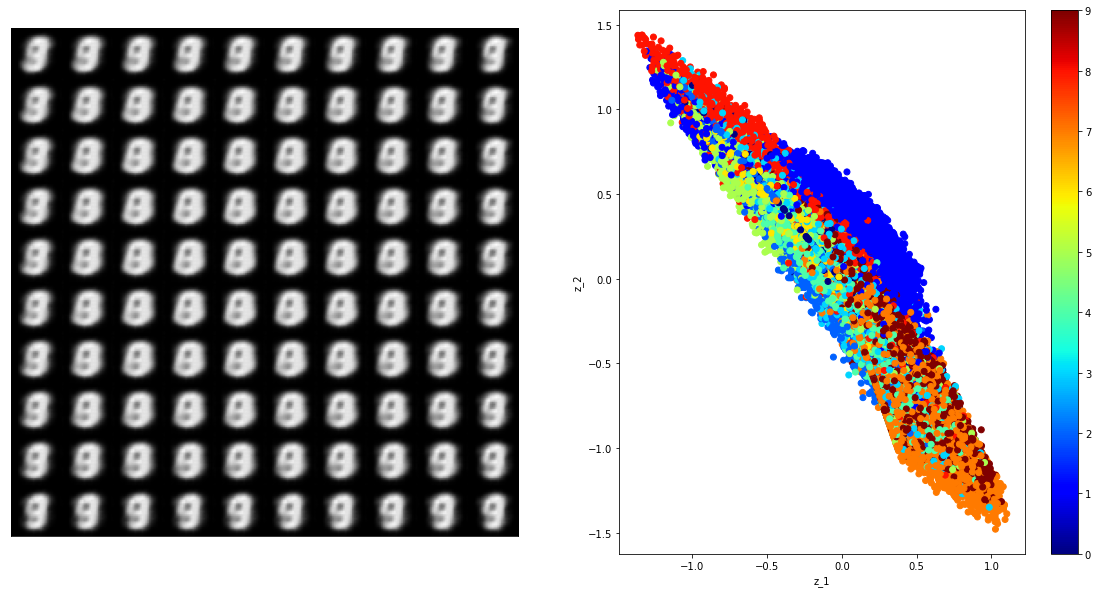

Epoch 2/30
469/469 [==============================] - 5s 10ms/step - loss: 194.1536 - reconstruction_loss: 187.3508 - kl_loss: 3.1370
Epoch 3/30
469/469 [==============================] - 5s 10ms/step - loss: 182.5520 - reconstruction_loss: 177.5239 - kl_loss: 3.3133
Epoch 4/30
469/469 [==============================] - 4s 10ms/step - loss: 176.8109 - reconstruction_loss: 172.4306 - kl_loss: 3.0671
Epoch 5/30
469/469 [==============================] - 4s 10ms/step - loss: 173.0092 - reconstruction_loss: 169.0052 - kl_loss: 2.9970
Epoch 6/30
469/469 [==============================] - 4s 10ms/step - loss: 169.2486 - reconstruction_loss: 164.1910 - kl_loss: 3.2287
Epoch 7/30
469/469 [==============================] - 4s 9ms/step - loss: 161.7097 - reconstruction_loss: 157.2345 - kl_loss: 3.2624
Epoch 8/30
469/469 [==============================] - 4s 10ms/step - loss: 158.5511 - reconstruction_loss: 154.5808 - kl_loss: 3.2574
Epoch 9/30
469/469 [==============================] - 4s 9ms/st

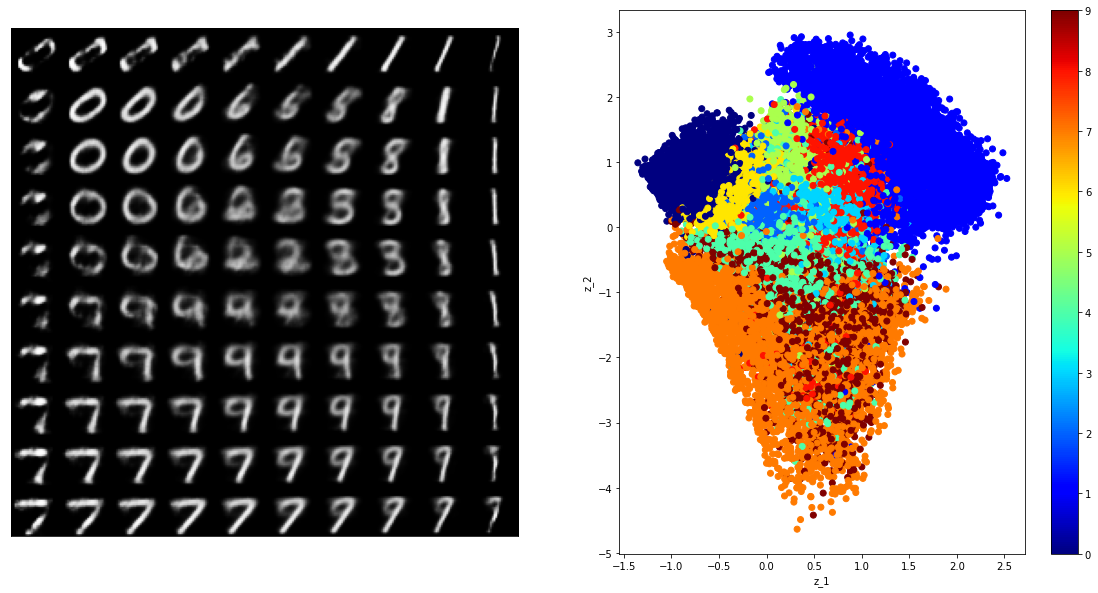

Epoch 12/30
469/469 [==============================] - 5s 11ms/step - loss: 152.7865 - reconstruction_loss: 149.3065 - kl_loss: 3.3394
Epoch 13/30
469/469 [==============================] - 5s 10ms/step - loss: 151.8886 - reconstruction_loss: 148.4338 - kl_loss: 3.3664
Epoch 14/30
469/469 [==============================] - 5s 10ms/step - loss: 151.4366 - reconstruction_loss: 147.9080 - kl_loss: 3.3671
Epoch 15/30
469/469 [==============================] - 5s 10ms/step - loss: 150.5647 - reconstruction_loss: 147.2998 - kl_loss: 3.3971
Epoch 16/30
469/469 [==============================] - 5s 10ms/step - loss: 149.9811 - reconstruction_loss: 146.8426 - kl_loss: 3.3951
Epoch 17/30
469/469 [==============================] - 5s 10ms/step - loss: 149.7272 - reconstruction_loss: 146.4958 - kl_loss: 3.4029
Epoch 18/30
469/469 [==============================] - 5s 10ms/step - loss: 149.4585 - reconstruction_loss: 146.1488 - kl_loss: 3.4022
Epoch 19/30
469/469 [==============================] - 

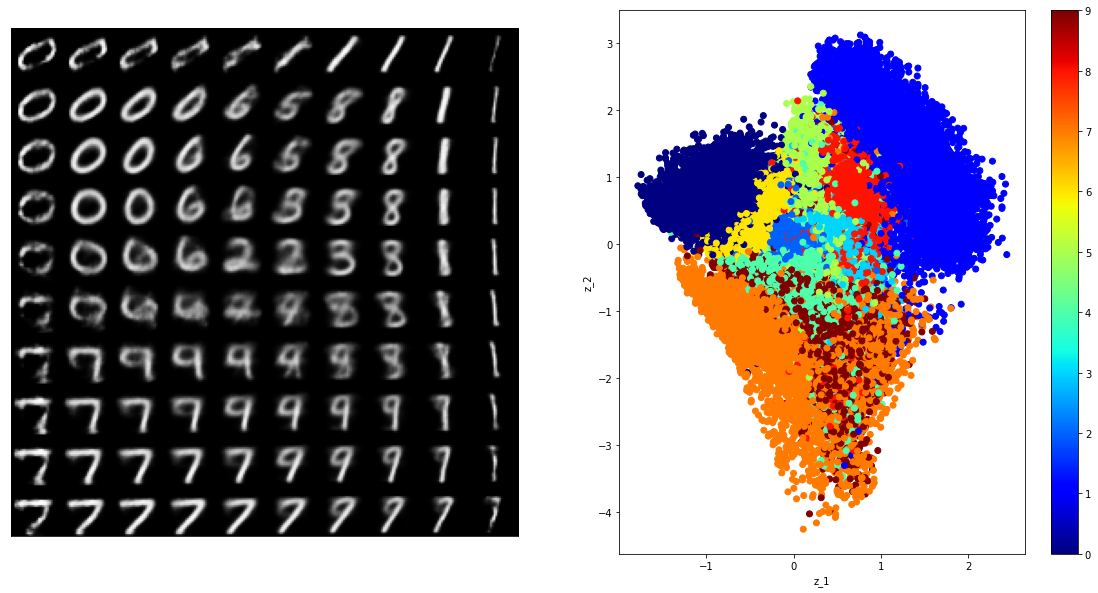

Epoch 22/30
469/469 [==============================] - 5s 11ms/step - loss: 148.2770 - reconstruction_loss: 145.0090 - kl_loss: 3.4199
Epoch 23/30
469/469 [==============================] - 5s 11ms/step - loss: 148.0495 - reconstruction_loss: 144.6827 - kl_loss: 3.4446
Epoch 24/30
469/469 [==============================] - 5s 11ms/step - loss: 147.8832 - reconstruction_loss: 144.5360 - kl_loss: 3.4469
Epoch 25/30
469/469 [==============================] - 5s 11ms/step - loss: 147.6585 - reconstruction_loss: 144.4377 - kl_loss: 3.4611
Epoch 26/30
469/469 [==============================] - 5s 11ms/step - loss: 147.6317 - reconstruction_loss: 144.0528 - kl_loss: 3.4571
Epoch 27/30
469/469 [==============================] - 5s 11ms/step - loss: 147.9449 - reconstruction_loss: 143.9609 - kl_loss: 3.4665
Epoch 28/30
469/469 [==============================] - 5s 11ms/step - loss: 146.5321 - reconstruction_loss: 143.7233 - kl_loss: 3.4618
Epoch 29/30
469/469 [==============================] - 

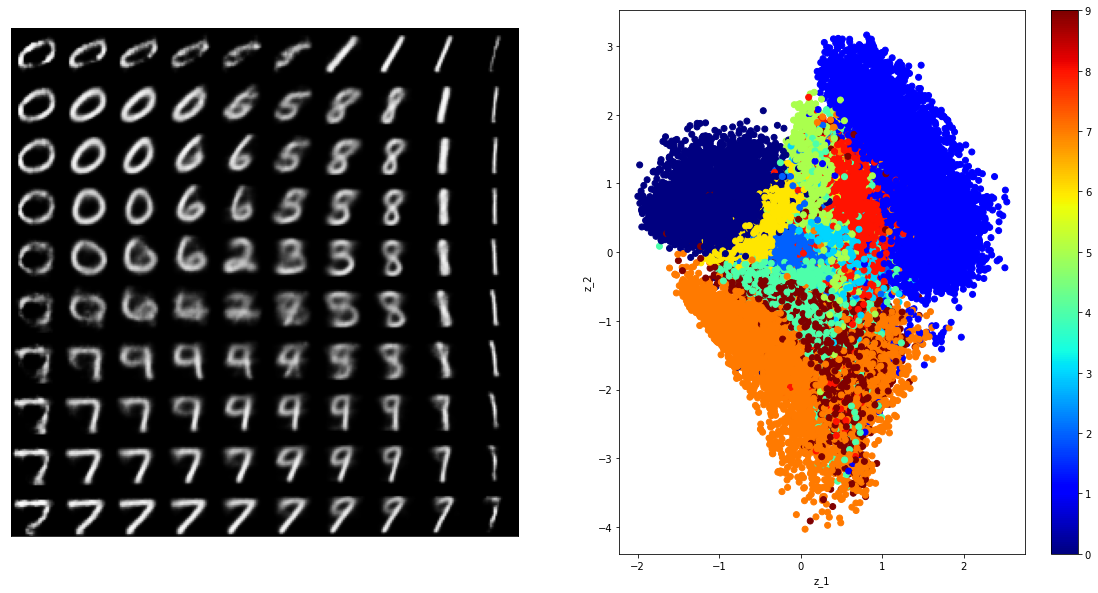

In [ ]:
epochs=30

vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam())
historyVAE = vae.fit(X_train, epochs=epochs, batch_size=128,callbacks=[DisplayCallbackVAE((X_train,y_train),10,10)])

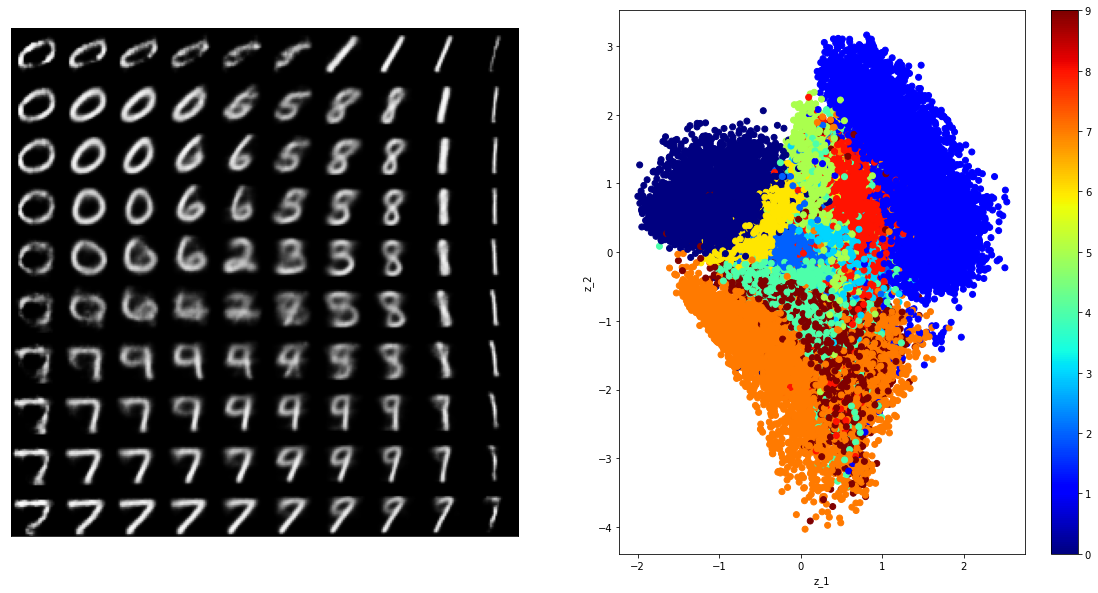

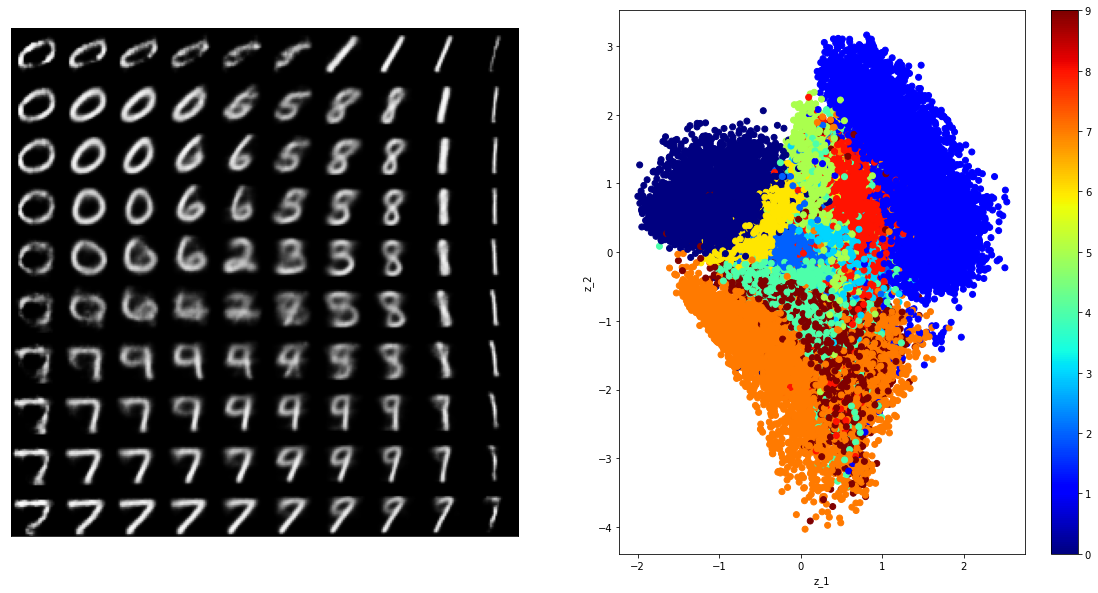

In [ ]:
img_rows, img_cols, img_chns = self.X_train.shape[1:]
latent_dim = 2
latent_space = np.array(vae.encoder.predict(self.X_train))
quantile_min = 0.01
quantile_max = 0.99
z1 = norm.ppf(np.linspace(quantile_min, quantile_max, self.n))
z2 = norm.ppf(np.linspace(quantile_max, quantile_min, self.n))
z_grid = np.dstack(np.meshgrid(z1, z2))
x_pred_grid = vae.decoder.predict(z_grid.reshape(self.n*self.n, latent_dim)).reshape(self.n, self.n, img_rows, img_cols)
plot_latent_space_cluster(x_pred_grid,latent_space[0],self.y_train,n=self.n, figsize=20)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(figsize, figsize/2))
ax1.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
ax1.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
cbar = ax2.scatter(latent_space[:, 0], latent_space[:, 1], c=y_true, cmap=plt.cm.jet)
fig.colorbar(cbar, ax=ax2)
ax2.set_xlabel('z_1')
ax2.set_ylabel('z_2')
plt.show()

## 1-10) Plot History

<h3 align="right" dir="rtl" >
در این قسمت نمودار loss داده های آموزش رسم شده است.
</h3>

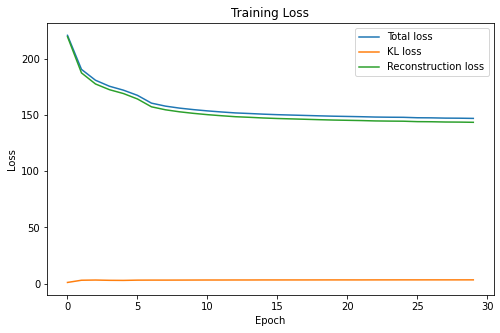

In [ ]:
plot_history(epochs,historyVAE)

## 1-11) Compare Input vs Output

<h3 align="right" dir="rtl" >
در این قسمت ورودی و خروجی 100 داده های ابتدایی مجموعه داده test به شبکه اعمالش شده و تصاویر خروجی شبکه در کنار تصاویر اولیه رسم شده اند که بتوان آنهارا مقایسه کرد.
</h3>

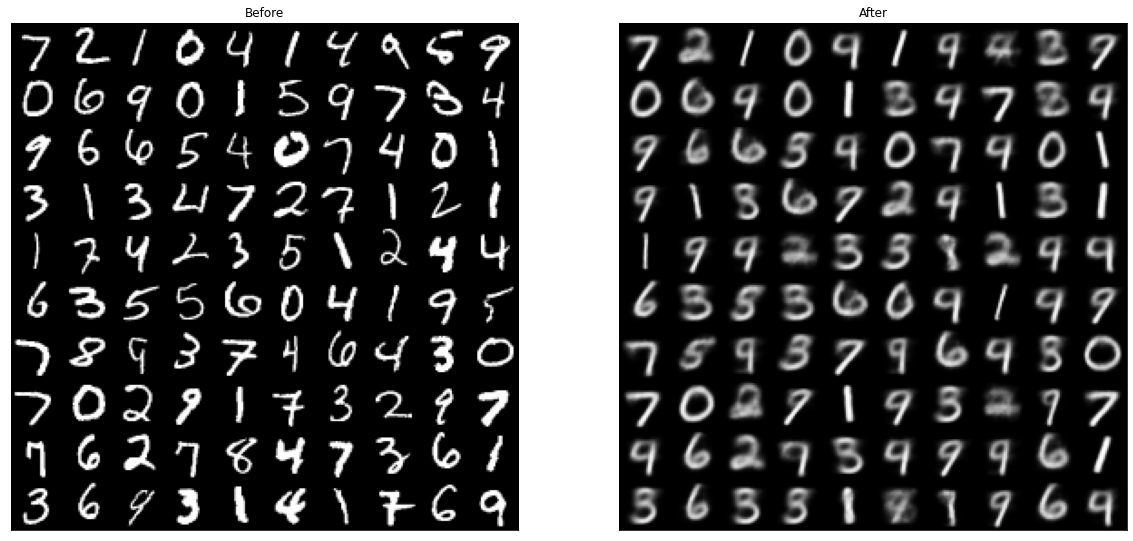

In [ ]:
n=10
latent_space = np.array(vae.encoder.predict(X_test[:n*n]))[0]
img_rows, img_cols, img_chns = X_test.shape[1:]
x_pred_grid = vae.decoder.predict(latent_space).reshape(n, n, img_rows, img_cols)
plot_after_before(X_test,x_pred_grid)

.  
.






# 2- Conditional Varitional Autoencoders

## 2-1) Reshape Dataset

<h3 align="right" dir="rtl" >
در مرحله اول با توجه به معماری مدل تعریف شده لازم است داده هارا به شکل یک بعدی تبدیل کنیم و همچنین برچسب های انهارا به شکل one hot در می آوریم.
</h3>

In [ ]:
y_train_2 = y_train.copy()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

## 2-2) Encoder Model

<h3 align="right" dir="rtl" >
مدل encoder در نظر گرفته شده برای این شبکه دو ورودی مجزا دارد. ورودی اول تصاویر و ورودی دوم برچسب متناظر با آنهارا دریافت میکند. در لایه بعدی این دو ورودی با یکدگیر concatenate میشوند. سپس خروجی این لایه به دولایه dense به ترتیب با 512 و256 نورون متصل میشود و در نهایت 4 لایه خروجی داریم که در هرکدام 2 نورون قرار دارد. خروجی اول Z_mean میباشد که پارامتر میانگین توزیع داده ها در فضای ثانویه را بدست میآورد. خروجی دوم نیز z_log_var است که پارامتر لگاریتم واریانس توزیع داده در فضای ثانویه را بدست می آورد. خروجی سوم نیز sample شد دو خروجی فوق میباشد. به طوریکه برروی این پارامترهای توزیع یک توزیع نرمال را اثر میدهد که خروجی تولید شده با با ورودی اولیه تفاوت داشته باشد. لایه خروجی 4 ام نیز از concatenate داده های sample شده و برچسب ها بدست می آید که برای اتصال به دیکدر استفاده میشود.
در اینجا نیز در دولایه اول از تابع فعالساز Relu و برای خروجی نیز از تابع خطی استفاده شده است.</h3>

In [ ]:
def make_CVAEencoder(latent_dim):
    encoder_inputs = keras.Input(shape=(784, ))
    conditional = keras.Input(shape=(10, ))
    inputs = concatenate([encoder_inputs, conditional])
    x = layers.Dense(512, activation='relu')(inputs)
    x = layers.Dense(256, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, activation='linear')(x)
    z_log_var = layers.Dense(latent_dim, activation='linear')(x)
    z = layers.Lambda(sampling)([z_mean, z_log_var,latent_dim])
    z_cond = concatenate([z, conditional])
    encoder = keras.Model([encoder_inputs, conditional], [z_mean,z_log_var,z_cond])
    return encoder

## 2-3) Decoder Model

<h3 align="right" dir="rtl" >
مدل دیکودر در نظر گرفته شده نیز ترتیب لایه هایی عکس مدل انکودر دارد و داده هارا از فضای ثانویه به فضای اولیه منتقل میکند. در لایه خروجی نیز از تابع فعالساز Sigmoid استفاده شده است.
</h3>

In [ ]:
def make_CVAEdecoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim+10,))
    x = layers.Dense(256, activation='relu')(latent_inputs)
    x = layers.Dense(512, activation='relu')(x)
    decoder_out = layers.Dense(784, activation='sigmoid')(x)
    decoder = keras.Model(latent_inputs, decoder_out)
    return decoder

## 2-4) CVAE Model

<h3 align="right" dir="rtl" >
پس از آماده سازی مدل های دیکدر و انکودر ، این دو مدل را با یکدگیر ترکیب میکنیم و مدل CVAE را بدست می آوریم. برای اینکار یک کلاس جدید به نام CVAE تعریف میکنیم که از کلاس مدل کتابخانه keras ارث برده است. سپس متد train_step آنرا دوباره تعریف میکنم. در این متد داده های ورودی را ابتدا به مدل encoder میدهیم که 3 خروجی z_mean ، z_log_var و z_cond را که از sample کردن دو پارامتر قبل والحاق برچسب ها به آن بوجود آمده است ، برگردانده میشوند. در مرحله بعد همانطور که قسمت قبل نیز ذکر شد ، خروجی z_cond را به مدل decoder میدهیم که آنرا به فضای اولیه برگرداند. پس از بدست آمدن خروجی شبکه در فضای اولیه خطای آنرا نسبت به ورودی اولیه شبکه بدست میآوریم و مقدار loss و metric های تعریف شده برای یادگیری شبکه را آپدیت میکنیم.
</h3>

In [ ]:
class CVAE(keras.Model):
    def __init__(self, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.latent_dim = 2
        self.encoder = make_CVAEencoder(self.latent_dim)
        self.decoder = make_CVAEdecoder(self.latent_dim)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean,z_log_var,z_cond = self.encoder([data[0][0], data[0][1]])
            reconstruction = self.decoder(z_cond)
            reconstruction_loss = K.sum(K.binary_crossentropy(data[0][0], reconstruction), axis=1)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## 2-5) Define Display Callback

<h3 align="right" dir="rtl" >
در این قسمت یک callback تعریف میکنیم که نسبت به ورودی که میگیرد ، هر چند ایپاک یکبار خروجی شبکه را رسم میکند. برای اینکار پس از اتمام هر ایپاک ، شمارنده ایپاک بررسی میشود که به interval در نظر گرفته شده رسیده است یا خیر و اگر رسیده بود با مدل آموزش دیده در آن لحظه فضای ثانویه و خروجی شبکه را بدست آورده و با استفاده از تابع plot_latent_space_cluster نمودارهایشان را رسم میکنیم.
</h3>

In [ ]:
class DisplayCallbackCVAE(keras.callbacks.Callback):
    def __init__(self,data,label,n,i,patience=0):
        super(DisplayCallbackCVAE, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.interval=i
        self.data = data
        self.n = n
        self.label= label


    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0 or epoch+1 == self.params.get('epochs', -1):
            latent_dim = 2
            latent_space,_,_ = self.model.encoder([self.data[0], y_train])
            quantile_min = 0.01
            quantile_max = 0.99
            z1 = norm.ppf(np.linspace(quantile_min, quantile_max, n))
            z2 = norm.ppf(np.linspace(quantile_max, quantile_min, n))
            z_grid = np.dstack(np.meshgrid(z1, z2))
            labels = np.zeros((100,10))
            labels[:,self.label]=1
            x_pred_grid = self.model.decoder.predict(concatenate([z_grid.reshape(self.n*self.n, latent_dim),labels])).reshape(self.n, self.n, 28, 28)
            plot_latent_space_cluster(x_pred_grid,latent_space,self.data[1],n=self.n, figsize=20)

### 2-8) Train Model

<h3 align="right" dir="rtl" >
در این قسمت تعریف و پیاده سازی شبکه CVAE به اتمام رسیده است و آنرا 30 ایپاک آموزش میدهیم. همچنین برای بررسی روند آموزش ، خروجی شبکه هر 10 ایپاک با استفاده از برچسب ورودی 3 رسم خواهد شد.
</h3>

Epoch 1/30
469/469 [==============================] - 2s 4ms/step - loss: 208.0173 - reconstruction_loss: 163.9422 - kl_loss: 2.7361


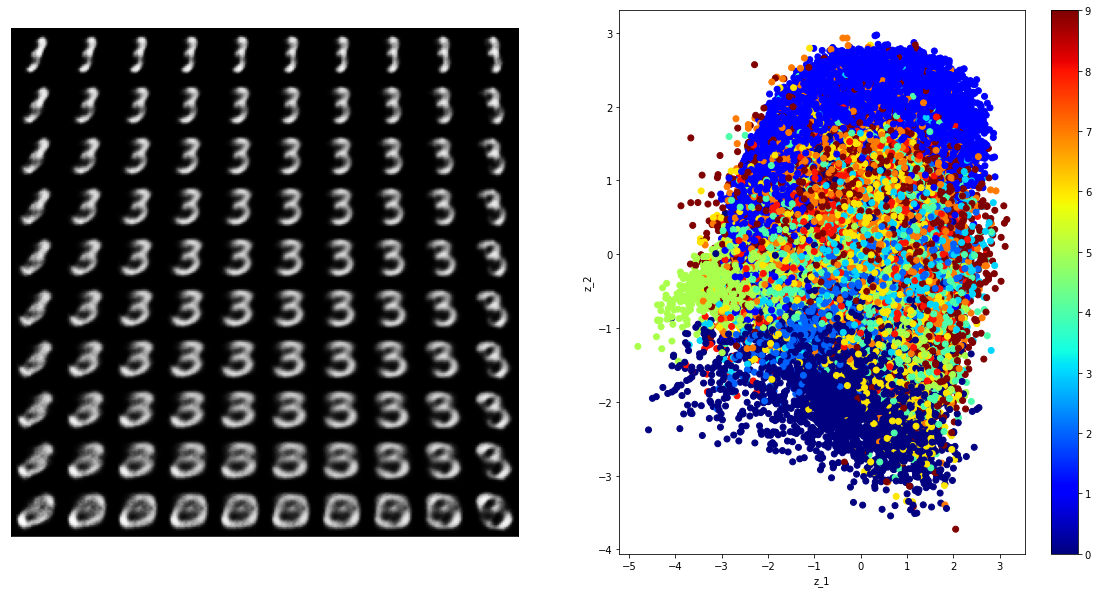

Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 139.2025 - reconstruction_loss: 135.4629 - kl_loss: 2.6213
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 134.7235 - reconstruction_loss: 131.4959 - kl_loss: 2.6275
Epoch 4/30
469/469 [==============================] - 2s 5ms/step - loss: 132.2794 - reconstruction_loss: 129.4489 - kl_loss: 2.6330
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 130.5217 - reconstruction_loss: 128.2004 - kl_loss: 2.6452
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 129.9543 - reconstruction_loss: 127.2723 - kl_loss: 2.6538
Epoch 7/30
469/469 [==============================] - 2s 5ms/step - loss: 129.1922 - reconstruction_loss: 126.5997 - kl_loss: 2.6529
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - loss: 128.7361 - reconstruction_loss: 126.0468 - kl_loss: 2.6627
Epoch 9/30
469/469 [==============================] - 2s 4ms/step - l

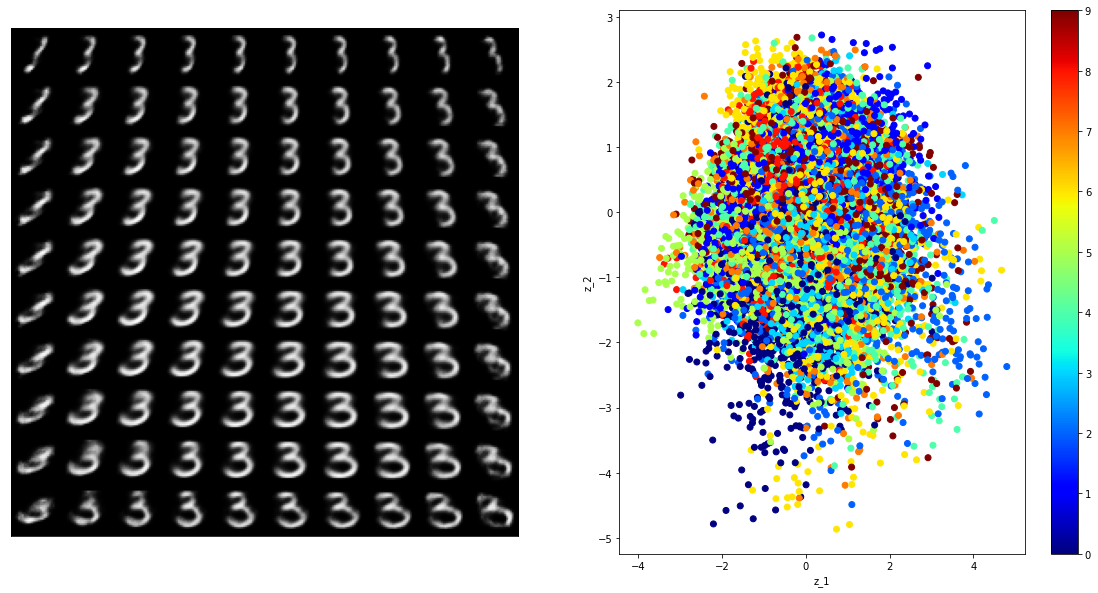

Epoch 12/30
469/469 [==============================] - 2s 5ms/step - loss: 126.7595 - reconstruction_loss: 124.4285 - kl_loss: 2.7088
Epoch 13/30
469/469 [==============================] - 2s 5ms/step - loss: 126.7714 - reconstruction_loss: 124.0600 - kl_loss: 2.7138
Epoch 14/30
469/469 [==============================] - 2s 5ms/step - loss: 126.4374 - reconstruction_loss: 123.7928 - kl_loss: 2.7242
Epoch 15/30
469/469 [==============================] - 2s 5ms/step - loss: 126.3501 - reconstruction_loss: 123.5253 - kl_loss: 2.7287
Epoch 16/30
469/469 [==============================] - 2s 5ms/step - loss: 126.1419 - reconstruction_loss: 123.2093 - kl_loss: 2.7409
Epoch 17/30
469/469 [==============================] - 2s 5ms/step - loss: 125.7153 - reconstruction_loss: 122.9396 - kl_loss: 2.7522
Epoch 18/30
469/469 [==============================] - 2s 5ms/step - loss: 125.9102 - reconstruction_loss: 122.7055 - kl_loss: 2.7633
Epoch 19/30
469/469 [==============================] - 2s 5ms/

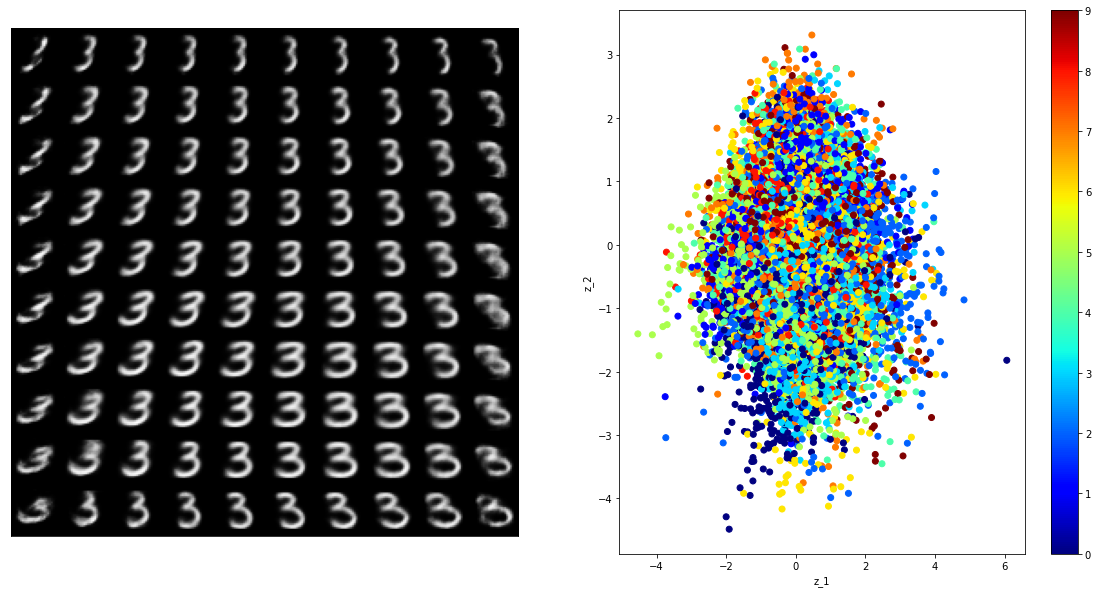

Epoch 22/30
469/469 [==============================] - 2s 5ms/step - loss: 124.5406 - reconstruction_loss: 121.8920 - kl_loss: 2.8045
Epoch 23/30
469/469 [==============================] - 2s 5ms/step - loss: 124.3386 - reconstruction_loss: 121.7081 - kl_loss: 2.8152
Epoch 24/30
469/469 [==============================] - 2s 5ms/step - loss: 124.0365 - reconstruction_loss: 121.5691 - kl_loss: 2.8152
Epoch 25/30
469/469 [==============================] - 2s 5ms/step - loss: 124.1618 - reconstruction_loss: 121.3644 - kl_loss: 2.8281
Epoch 26/30
469/469 [==============================] - 2s 5ms/step - loss: 123.8547 - reconstruction_loss: 121.1272 - kl_loss: 2.8382
Epoch 27/30
469/469 [==============================] - 2s 5ms/step - loss: 123.5482 - reconstruction_loss: 120.9886 - kl_loss: 2.8424
Epoch 28/30
469/469 [==============================] - 2s 5ms/step - loss: 123.4854 - reconstruction_loss: 120.8729 - kl_loss: 2.8564
Epoch 29/30
469/469 [==============================] - 2s 5ms/

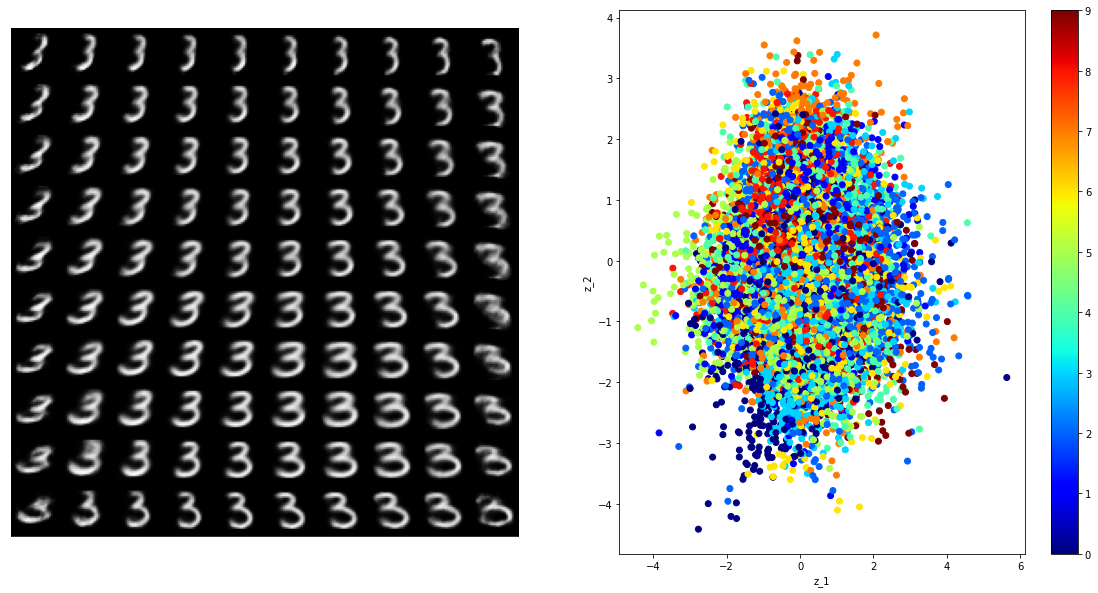

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f64310584d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


In [ ]:
latent_dim = 2

epochs =30
cvae = CVAE()
cvae.compile(optimizer=keras.optimizers.Adam())
historyCVAE = cvae.fit([X_train, y_train], epochs=epochs, batch_size=128,callbacks=[DisplayCallbackCVAE((X_train,y_train_2),label=3,n=10,i=10)])

## 2-9) Plot History

<h3 align="right" dir="rtl" >
در این قسمت نمودار loss داده های آموزش رسم شده است.
</h3>

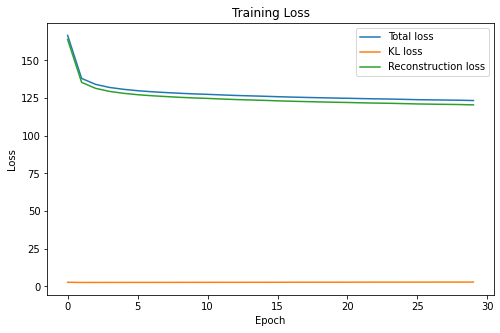

In [ ]:
plot_history(epochs,historyCVAE)

## 2-10) Compare Input vs Output of model

<h3 align="right" dir="rtl" >
در این قسمت نیز ورودی و خروجی متناظر با ورودی ها برای 100 داده ابتدایی مجموعه داده test رسم شده است. با توجه به ساختار CVAE مشاهده میشود که تمام خروجی ها در کلاس داده های ورودی قرار دارند و صرفا اندکی تغییر یافته اند ولی کلاسشان تغییر نکرده است.
</h3>

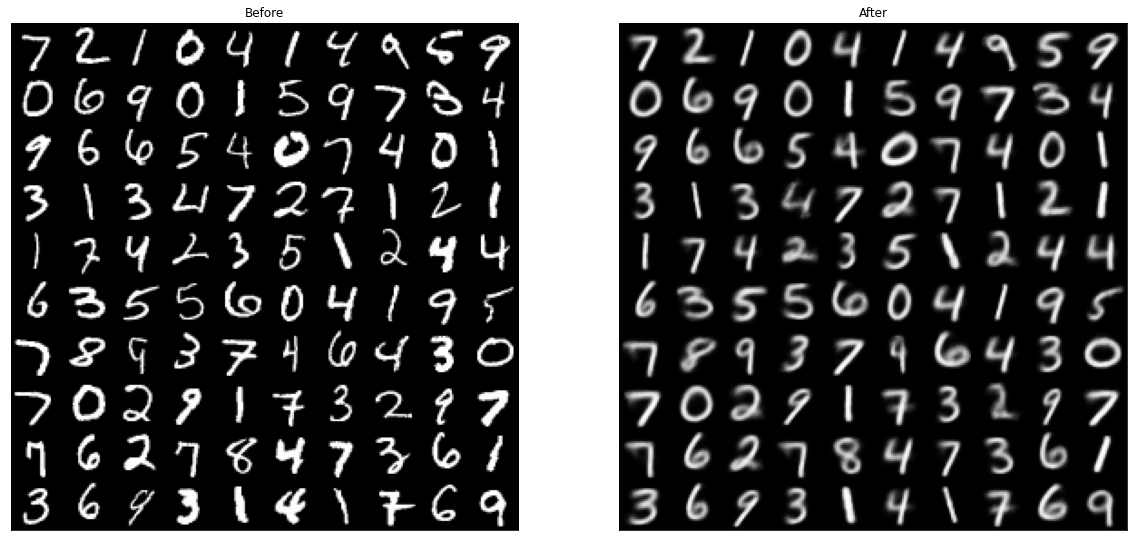

In [ ]:
n=10
figsize=20
latent_space,_,_ = cvae.encoder([X_test[:n*n], y_test[:n*n]])
x_pred_grid = cvae.decoder.predict(concatenate([latent_space,y_test[:n*n]])).reshape(n, n, 28, 28)
plot_after_before(X_test,x_pred_grid)